## HW 11 - Data fitting with various functions - Due Monday Nov 7, 2021


Dowload the data from the SDSS DR16:<br>
https://data.sdss.org/sas/dr16/apogee/spectro/aspcap/r12/l33/allStar-r12-l33.fits
NOTE: it is a large file and will take a while.


Using masking. Select the approprate fitting function and fit the following selections of the data:
1. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LogG (LOGG\_ERR)__<br>
<br>
2. Select stars only with with $GLAT < -10$ or $GLAT > 10$ <br>
   __Fit {\bf  Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>
<br>
3. Select stars only with with $-2< GLAT < 2$ <br>
   __Fit {\bf  Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>
<br>
4. Select stars only with with $GLAT < -10$ or $GLAT > 10$ <br>
   __Fit {\bf  TEFF,  (TEFF\_ERR)   vs.  (J - K) (J\_ERR, K\_ERR)__<br>
<br>
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit {\bf  GLON  vs.  VHEILO\_AVG (VERR)__<br>
<br>
6. __Fit {\bf NVISITS vs.  VSCATTER (VERR)__ For NVISITS $>= 1$<br>
<br>
7. __Fit {\bf  Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For each of the above selections:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend)

ColDefs(
    name = 'APSTAR_ID'; format = '57A'
    name = 'TARGET_ID'; format = '47A'
    name = 'ASPCAP_ID'; format = '59A'
    name = 'FILE'; format = '39A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '8A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '16A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '192A'
    name = 'SURVEY'; format = '35A'
    name = 'PROGRAMNAME'; format = '18A'
    na

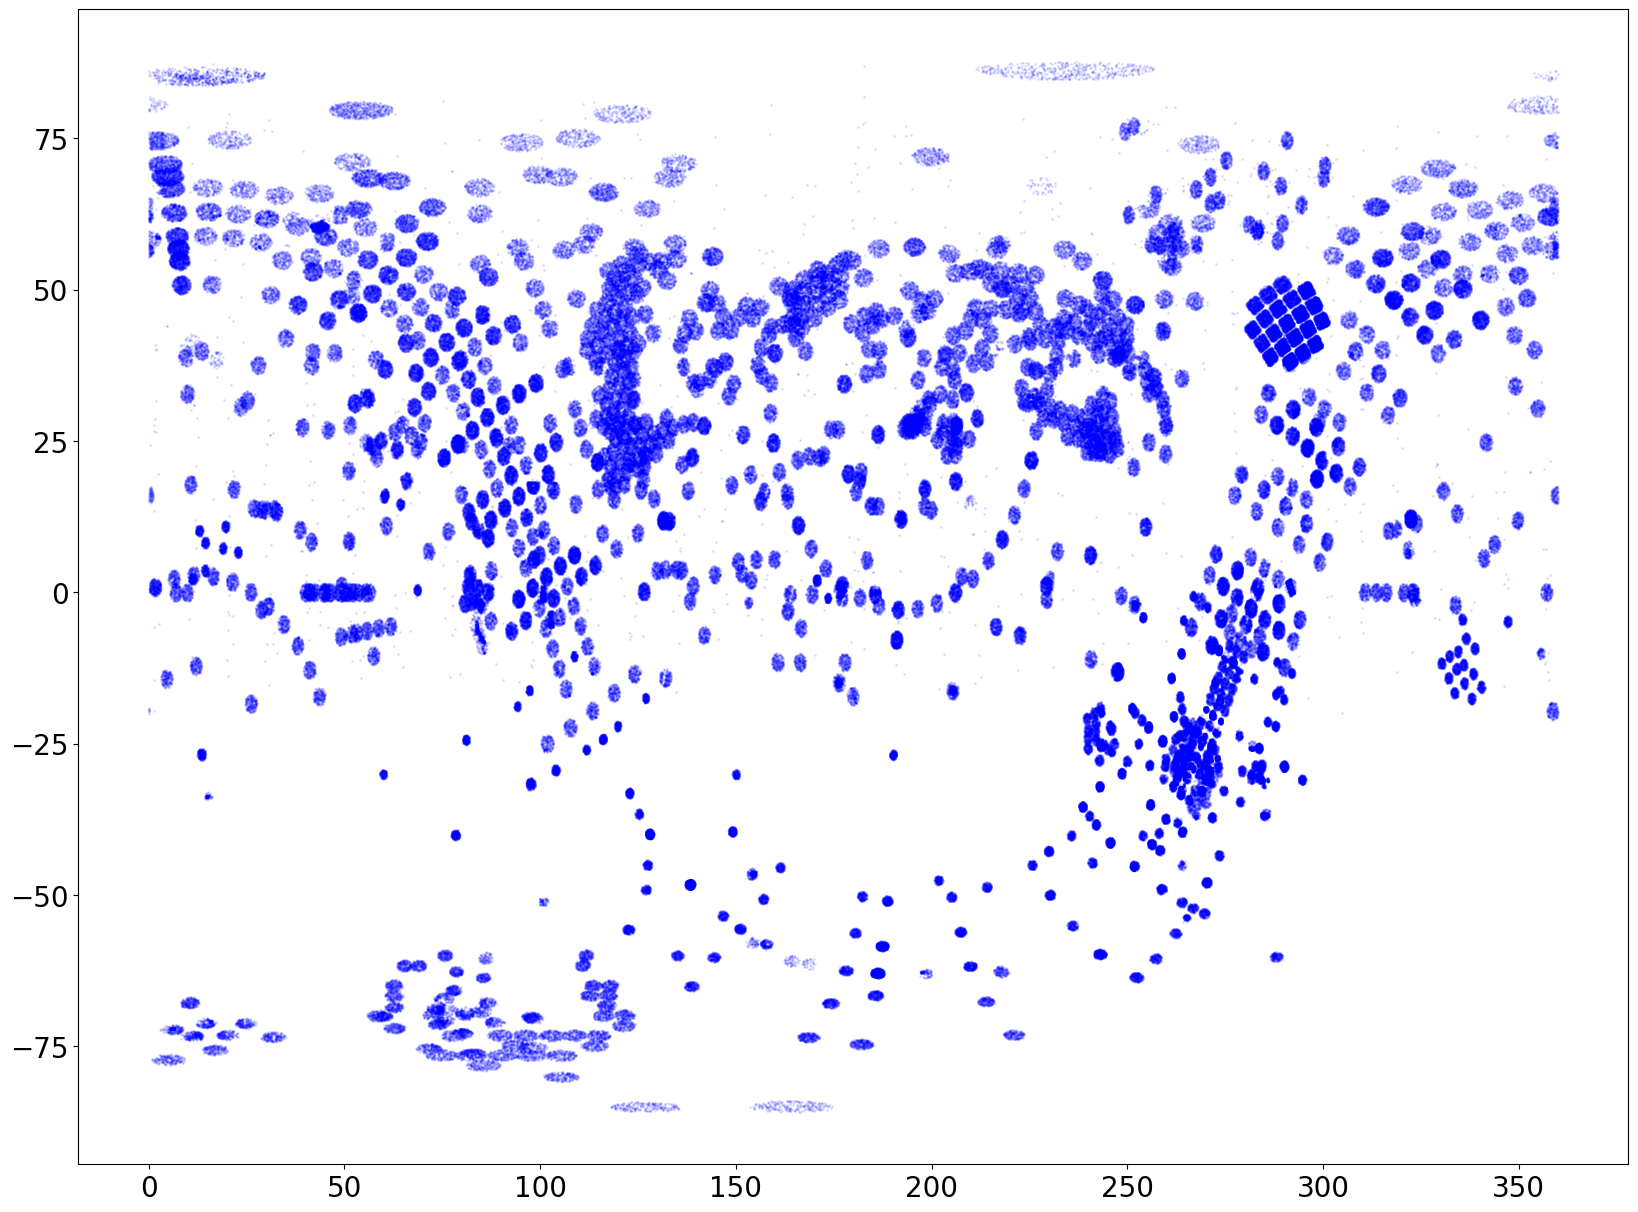

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def logfit(x,a,b,c,d):
    return a*np.log(b*x + c) + d

def gausian(x,mu,sigma):
    part1 = (1.0/np.sqrt(2*np.pi*sigma**2))
    return (part1*(np.exp((-1*x - mu)**2/(2*sigma**2))))

def lorentzian_cauchy (x,a,b,c):
    return (c)*(b**2/((x-a)**2 + b**2))

def sigmoid(x,a,b,c,d):
    return (c/(1 + np.exp(-b*(x-a))) + d)

# READ IN FITS FILES
star_hdus = fits.open('allStar-r12-l33.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

# TWO BITWISE FLAGS FOR BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

In [2]:
def mcFit2(func, x, y, y_err, x_err, p0=[1,1]):
    slope = list()
    y_ints = list()
    iters = 5
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 

        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])

    return (np.median(slope),np.median(y_ints))


def mcFit3(func, x, y, y_err, x_err,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 5
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 

        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

def mcFit4(func, x, y, y_err, x_err, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 5
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 

        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])

    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


C:\Users\April\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


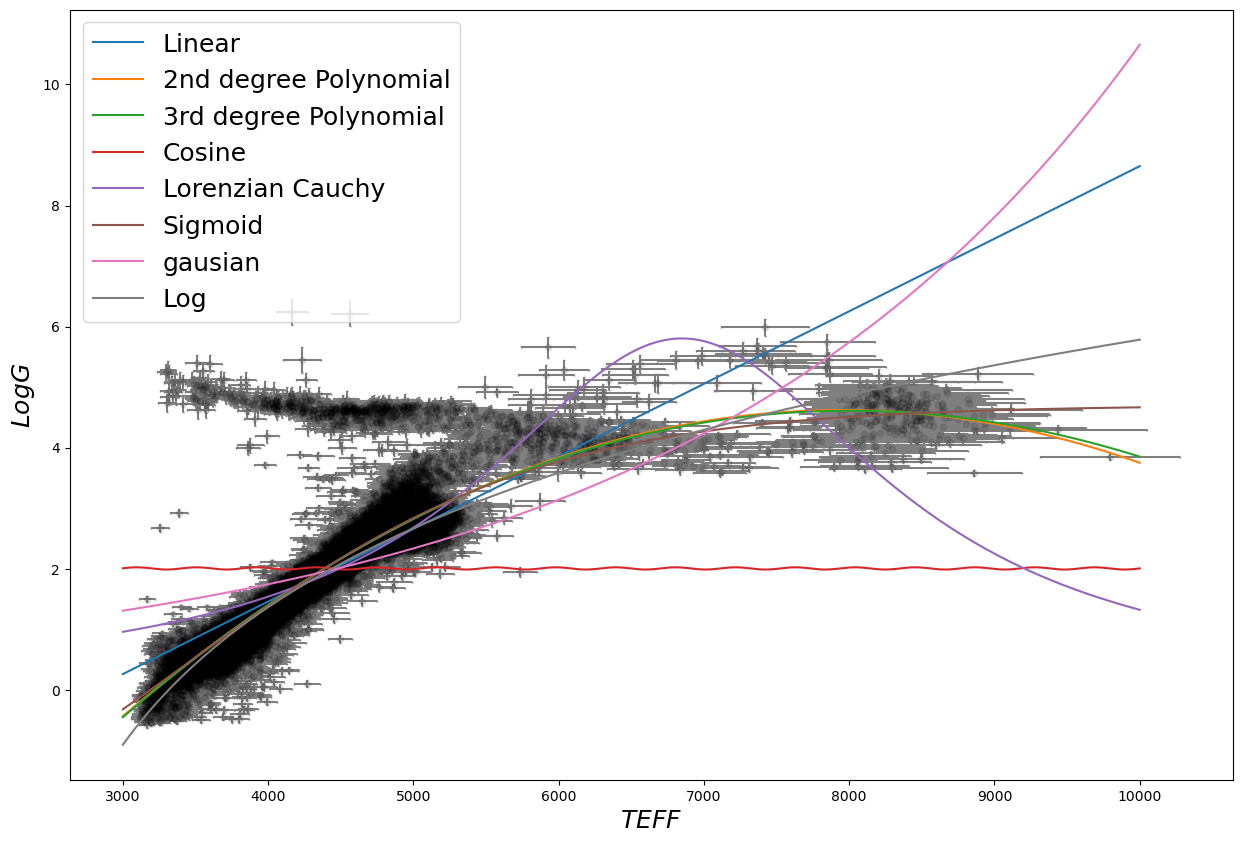

In [3]:
#problem 1 Select stars only with with  −1<𝐺𝐿𝐴𝑇<1, Fit TEFF (TEFF_ERR) vs. LogG (LOGG_ERR)
mask_1 = ((star['GLAT'][good] > -1) & (star['GLAT'][good] <1)) & ((star['TEFF'][good] > -9999) & (star['LOGG'][good] > -9999))
xdat = star['TEFF'][good][mask_1]
ydat = star['LOGG'][good][mask_1]
xdat_err = star['TEFF_ERR'][good][mask_1]
ydat_err = star['LOGG_ERR'][good][mask_1]

#slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err, p0=[0.001,-1])

#a_poly_2,b_poly_2,c_poly_2 = mcFit3(poly2, xdat, ydat, ydat_err, xdat_err, p0 = [-2.0e-07, 0.003, -8.5])
#a_poly_3,b_poly_3,c_poly_3,d_poly_3 = mcFit4(poly3, xdat, ydat, ydat_err, xdat_err, p0=[2.2e-12, -2.4e-07, 0.003, -8.6])
#a_cos,b_cos,c_cos,d_cos = mcFit4(cosfit, xdat, ydat, ydat_err, xdat_err, p0=[4, 0.015, -1.3, 0])
#a_lorentz, b_lorentz, c_lorentz = mcFit3(lorentzian_cauchy,xdat, ydat, ydat_err, xdat_err, p0 = [6500,4000,3])
#a_sig, b_sig, c_sig, d_sig = mcFit4(sigmoid, xdat, ydat, ydat_err, xdat_err, p0=[3200,0.0008,8,-4])
#a_4,b_4,c_4,d_4 = mcFit4(logfit, xdat, ydat, ydat_err, xdat_err, p0=[2,0.6,-1000,-50])
#mu, sigma = mcFit2(gausian,xdat, ydat, ydat_err, xdat_err, p0=[3000,1700])
a_exp,b_exp,c_exp,d_exp = mcFit4(exponential,xdat, ydat, ydat_err, xdat_err, p0=[-0.1,0.3,1.9,1])
#print(a_exp,b_exp,c_exp,d_exp)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
xfine = np.linspace(3000., 10000., 1000) 
ax.scatter(xdat,ydat,s=20,c='black', alpha=0.1)
ax.errorbar(xdat,ydat,xerr= xdat_err,yerr=ydat_err, c='tab:gray', 
            fmt='.', markersize=0.75, capsize=1 ,zorder=0)

#ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')
#ax.plot(xfine, poly2(xfine, np.mean(a_poly_2), np.mean(b_poly_2), np.mean(c_poly_2)), label='2nd degree Polynomial')
#ax.plot(xfine, poly3(xfine, np.mean(a_poly_3), np.mean(b_poly_3), np.mean(c_poly_3), np.mean(d_poly_3)), label='3rd degree Polynomial')
#ax.plot(xfine, cosfit(xfine, np.mean(a_cos), np.mean(b_cos), np.mean(c_cos), np.mean(d_cos)), label='Cosine')
#ax.plot(xfine, lorentzian_cauchy(xfine, np.mean(a_lorentz), np.mean(b_lorentz), np.mean(c_lorentz)), label='Lorenzian Cauchy')
#ax.plot(xfine, sigmoid(xfine, np.mean(a_sig), np.mean(b_sig), np.mean(c_sig),np.mean(d_sig)), label='Sigmoid')
#ax.plot(xfine, gausian(xfine, np.mean(mu), np.mean(sigma)), label='gausian')
#ax.plot(xfine, logfit(xfine, np.mean(a_4), np.mean(b_4), np.mean(c_4), np.mean(d_4)), label='Log')
ax.plot(xfine, exponential(xfine, np.mean(a_exp), np.mean(b_exp), np.mean(c_exp), np.mean(d_exp)), label='Exponential')

plt.legend(loc='best', fontsize=18)
ax.set_xlabel('$TEFF$', fontsize=18)
ax.set_ylabel('$LogG$', fontsize=18)

plt.show()


C:\Users\April\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


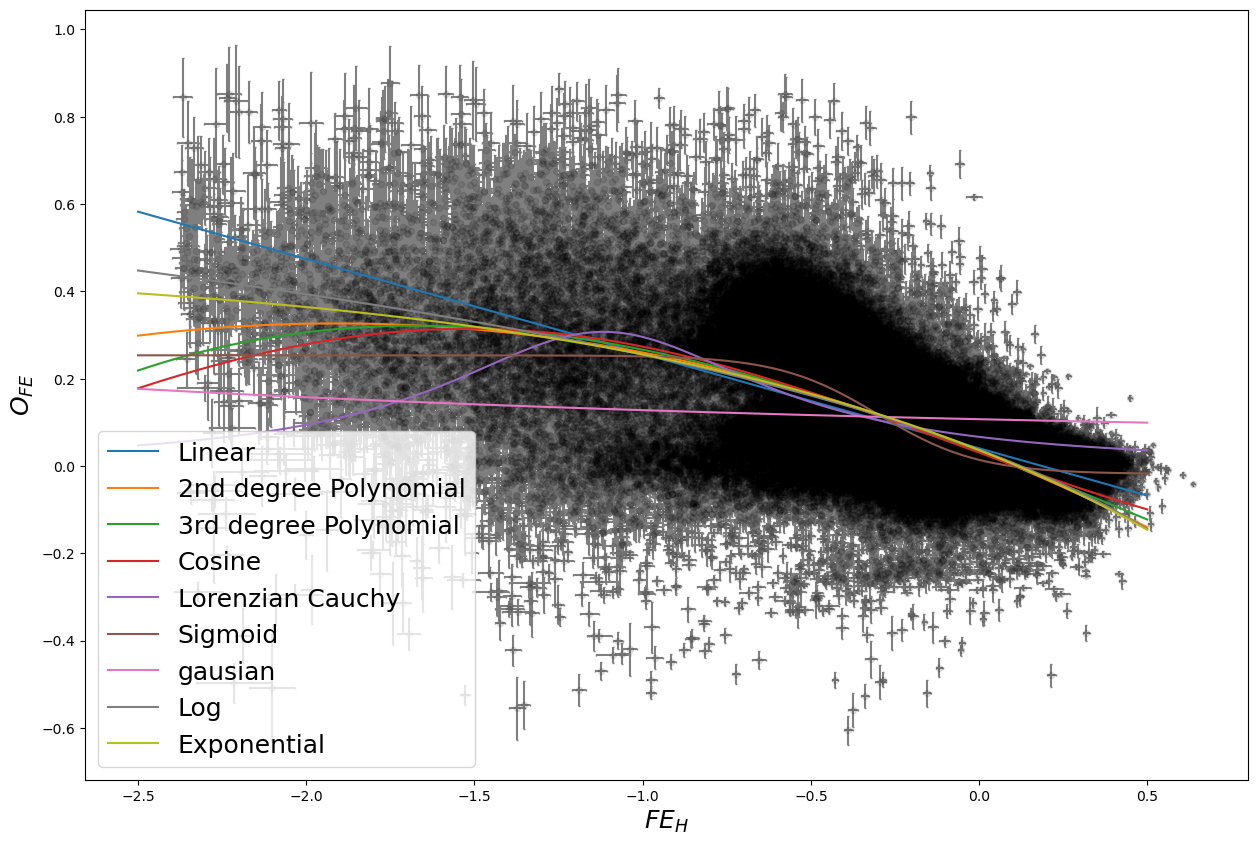

In [34]:
# problem 2: Select stars only with with  𝐺𝐿𝐴𝑇<−10  or  𝐺𝐿𝐴𝑇>10  Fit {\bf Fe_H, (Fe_H_ERR) vs. O_FE (O_FE_ERR)
mask_1 = ((star['GLAT'][good] < -10) | (star['GLAT'][good] >10)) & ((star['Fe_H'][good] > -9999) & (star['O_FE'][good] > -9999))
xdat = star['Fe_H'][good][mask_1]
ydat = star['O_FE'][good][mask_1]
xdat_err = star['Fe_H_ERR'][good][mask_1]
ydat_err = star['O_FE_ERR'][good][mask_1]

slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err)
a_poly_2,b_poly_2,c_poly_2 = mcFit3(poly2, xdat, ydat, ydat_err, xdat_err)
a_poly_3,b_poly_3,c_poly_3,d_poly_3 = mcFit4(poly3, xdat, ydat, ydat_err, xdat_err)
#print(a_poly_3,b_poly_3,c_poly_3,d_poly_3)
a_cos,b_cos,c_cos,d_cos = mcFit4(cosfit, xdat, ydat, ydat_err, xdat_err)
#print(a_cos,b_cos,c_cos,d_cos)
mu, sigma = mcFit2(gausian,xdat, ydat, ydat_err, xdat_err, p0=[-0.5,4])

a_lorentz, b_lorentz, c_lorentz = mcFit3(lorentzian_cauchy,xdat, ydat, ydat_err, xdat_err, p0=[-0.2,1,0.7])
#print(a_lorentz, b_lorentz, c_lorentz)
a_sig, b_sig, c_sig, d_sig = mcFit4(sigmoid, xdat, ydat, ydat_err, xdat_err, p0=[-0.5,10,-0.5,0.5])
#print(a_sig, b_sig, c_sig, d_sig)
a_4,b_4,c_4,d_4 = mcFit4(logfit, xdat, ydat, ydat_err, xdat_err, p0=[0.2,0.1,0.3,0.4])
#print(a_4,b_4,c_4,d_4)
a_exp,b_exp,c_exp,d_exp = mcFit4(exponential,xdat, ydat, ydat_err, xdat_err, p0=[-0.1,0.3,1.9,1])
#print(a_exp,b_exp,c_exp,d_exp)
xfine = np.linspace(-2.5, 0.5, 1000)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(xdat,ydat,s=20,c='black',alpha=0.1)
ax.errorbar(xdat,ydat,xerr= xdat_err,yerr=ydat_err, c='tab:gray', 
            fmt='.', markersize=0.75, capsize=1 ,zorder=0)

ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')
ax.plot(xfine, poly2(xfine, np.mean(a_poly_2), np.mean(b_poly_2), np.mean(c_poly_2)), label='2nd degree Polynomial')
ax.plot(xfine, poly3(xfine, np.mean(a_poly_3), np.mean(b_poly_3), np.mean(c_poly_3), np.mean(d_poly_3)), label='3rd degree Polynomial')
ax.plot(xfine, cosfit(xfine, np.mean(a_cos), np.mean(b_cos), np.mean(c_cos), np.mean(d_cos)), label='Cosine')
ax.plot(xfine, lorentzian_cauchy(xfine, np.mean(a_lorentz), np.mean(b_lorentz), np.mean(c_lorentz)), label='Lorenzian Cauchy')
ax.plot(xfine, sigmoid(xfine, np.mean(a_sig), np.mean(b_sig), np.mean(c_sig),np.mean(d_sig)), label='Sigmoid')
ax.plot(xfine, gausian(xfine, np.mean(mu), np.mean(sigma)), label='gausian')
ax.plot(xfine, logfit(xfine, np.mean(a_4), np.mean(b_4), np.mean(c_4), np.mean(d_4)), label='Log')
ax.plot(xfine, exponential(xfine, np.mean(a_exp), np.mean(b_exp), np.mean(c_exp), np.mean(d_exp)), label='Exponential')

plt.legend(loc='best', fontsize=18)


ax.set_xlabel('$FE_{H}$', fontsize=18)
ax.set_ylabel('$O_{FE}$', fontsize=18)

plt.show()


C:\Users\April\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


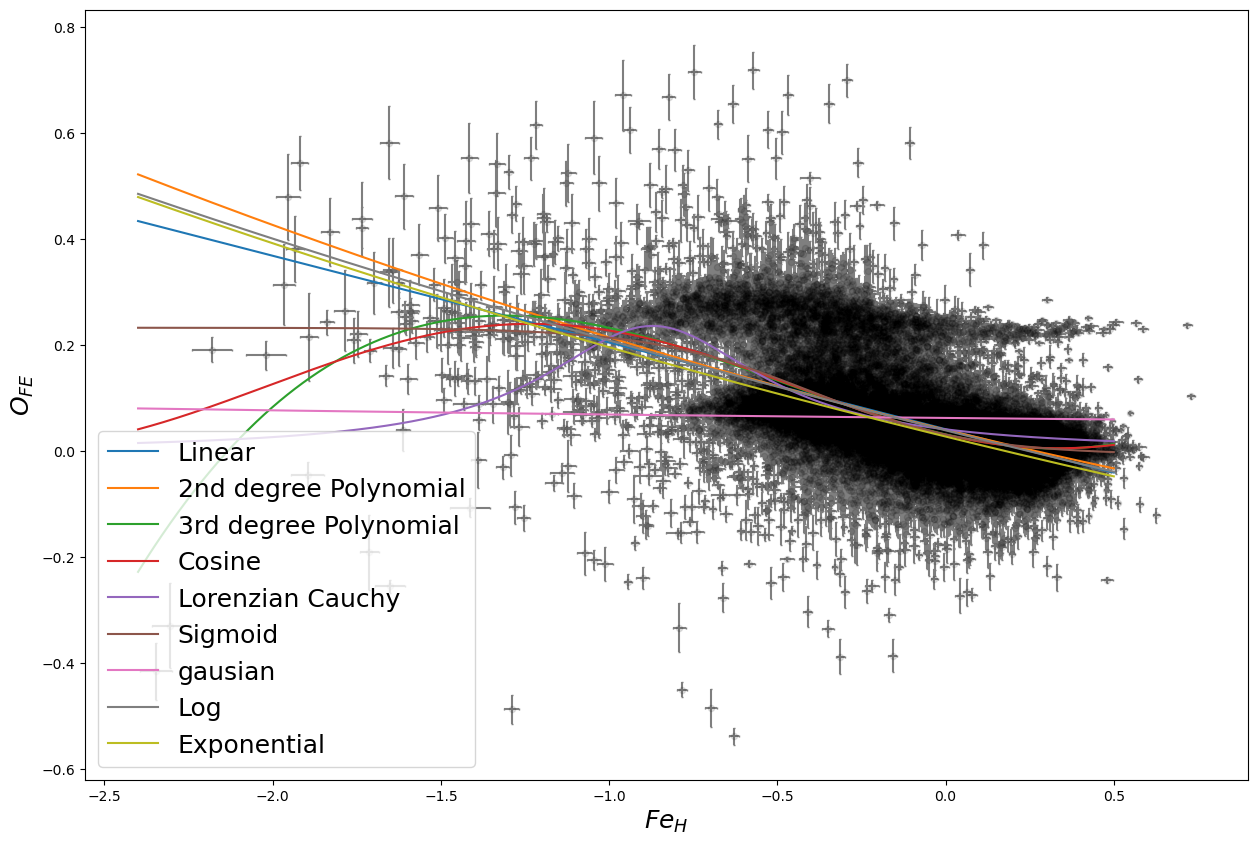

In [92]:
#problem 3 Select stars only with with  −2<𝐺𝐿𝐴𝑇<2 Fit {\bf Fe_H, (Fe_H_ERR) vs. O_FE (O_FE_ERR)
mask_1 = ((star['GLAT'][good] > -2) & (star['GLAT'][good] <2)) & ((star['Fe_H'][good] > -9999) & (star['O_FE'][good] > -9999))
xdat = star['Fe_H'][good][mask_1]
ydat = star['O_FE'][good][mask_1]
xdat_err = star['Fe_H_ERR'][good][mask_1]
ydat_err = star['O_FE_ERR'][good][mask_1]


slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err)
a_poly_2,b_poly_2,c_poly_2 = mcFit3(poly2, xdat, ydat, ydat_err, xdat_err, p0=[0.01,-0.1,0.03])
#print(a_poly_2,b_poly_2,c_poly_2)
a_poly_3,b_poly_3,c_poly_3,d_poly_3 = mcFit4(poly3, xdat, ydat, ydat_err, xdat_err, p0=[0.2, 0.2, -0.1,0.03])
#print(a_poly_3,b_poly_3,c_poly_3,d_poly_3)
a_cos,b_cos,c_cos,d_cos = mcFit4(cosfit, xdat, ydat, ydat_err, xdat_err)
#print(a_cos,b_cos,c_cos,d_cos)
mu, sigma = mcFit2(gausian,xdat, ydat, ydat_err, xdat_err, p0=[-1.6,1.8])

a_lorentz, b_lorentz, c_lorentz = mcFit3(lorentzian_cauchy,xdat, ydat, ydat_err, xdat_err, p0=[0,0.7,0.2])
#print(a_lorentz, b_lorentz, c_lorentz)
a_sig, b_sig, c_sig, d_sig = mcFit4(sigmoid, xdat, ydat, ydat_err, xdat_err, p0=[0.5,4,-0.2,0.2])
#print(a_sig, b_sig, c_sig, d_sig)
a_4,b_4,c_4,d_4 = mcFit4(logfit, xdat, ydat, ydat_err, xdat_err, p0=[-0.5,-1.2,1.4,-0.8])
#print(a_4,b_4,c_4,d_4)
a_exp,b_exp,c_exp,d_exp = mcFit4(exponential,xdat, ydat, ydat_err, xdat_err, p0=[0.7,-0.1,0.1,-0.7])
#print(a_exp,b_exp,c_exp,d_exp)

xfine = np.linspace(-2.4, 0.5, 1000)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(xdat,ydat,s=20,c='black',alpha=0.1)
ax.errorbar(xdat,ydat,xerr= xdat_err,yerr=ydat_err, c='tab:gray', 
            fmt='.', markersize=0.75, capsize=1 ,zorder=0)
ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')
ax.plot(xfine, poly2(xfine, np.mean(a_poly_2), np.mean(b_poly_2), np.mean(c_poly_2)), label='2nd degree Polynomial')
ax.plot(xfine, poly3(xfine, np.mean(a_poly_3), np.mean(b_poly_3), np.mean(c_poly_3), np.mean(d_poly_3)), label='3rd degree Polynomial')
ax.plot(xfine, cosfit(xfine, np.mean(a_cos), np.mean(b_cos), np.mean(c_cos), np.mean(d_cos)), label='Cosine')
ax.plot(xfine, lorentzian_cauchy(xfine, np.mean(a_lorentz), np.mean(b_lorentz), np.mean(c_lorentz)), label='Lorenzian Cauchy')
ax.plot(xfine, sigmoid(xfine, np.mean(a_sig), np.mean(b_sig), np.mean(c_sig),np.mean(d_sig)), label='Sigmoid')
ax.plot(xfine, gausian(xfine, np.mean(mu), np.mean(sigma)), label='gausian')
ax.plot(xfine, logfit(xfine, np.mean(a_4), np.mean(b_4), np.mean(c_4), np.mean(d_4)), label='Log')
ax.plot(xfine, exponential(xfine, np.mean(a_exp), np.mean(b_exp), np.mean(c_exp), np.mean(d_exp)), label='Exponential')

plt.legend(loc='best', fontsize=18)



ax.set_xlabel('$Fe_{H}$', fontsize=18)
ax.set_ylabel('$O_{FE}$', fontsize=18)

plt.show()


0.5308569565056881 -0.00016663095882398814 2.0135834481228057 -1.1169985506847728


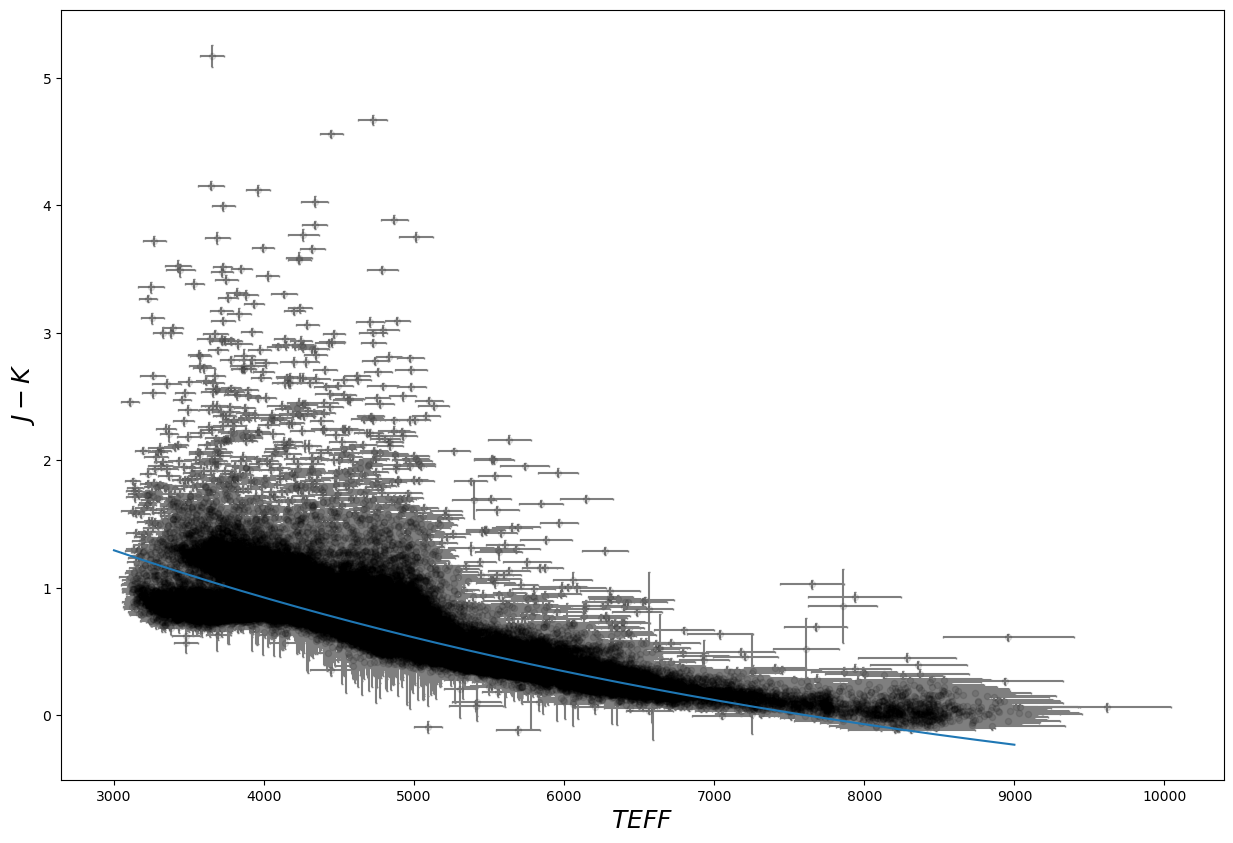

In [22]:
#problem 4 Select stars only with with  𝐺𝐿𝐴𝑇<−10  or  𝐺𝐿𝐴𝑇>10  Fit {\bf TEFF, (TEFF_ERR) vs. (J - K) (J_ERR, K_ERR)
mask_1 = ((star['GLAT'][good] < -10) | (star['GLAT'][good] >10)) &(star['TEFF'][good] > -9999) & ((star['J'][good]-star['K'][good])<9999) & (np.sqrt(star['J_ERR'][good]**2+star['K_ERR'][good]**2)<8)
xdat = star['TEFF'][good][mask_1]
ydat = star['J'][good][mask_1]-star['K'][good][mask_1]
xdat_err = star['TEFF_ERR'][good][mask_1]
ydat_err = np.sqrt(star['J_ERR'][good][mask_1]**2+star['K_ERR'][good][mask_1]**2)


#slope, intercept = mcFit2(linear, xdat, ydat, ydat_err)
#a_poly_2,b_poly_2,c_poly_2 = mcFit3(poly2, xdat, ydat, ydat_err, xdat_err)
#print(a_poly_2,b_poly_2,c_poly_2)
#a_poly_3,b_poly_3,c_poly_3,d_poly_3 = mcFit4(poly3, xdat, ydat, ydat_err, xdat_err)
#print(a_poly_3,b_poly_3,c_poly_3,d_poly_3)

#a_lorentz, b_lorentz, c_lorentz = mcFit3(lorentzian_cauchy,xdat, ydat, ydat_err, xdat_err, p0=[4000,1000,1.5])
#print(a_lorentz, b_lorentz, c_lorentz)
#a_sig, b_sig, c_sig, d_sig = mcFit4(sigmoid, xdat, ydat, ydat_err, xdat_err,p0=[4000,6,2.5,0.3])
#print(a_sig, b_sig, c_sig, d_sig)
#a_4,b_4,c_4,d_4 = mcFit4(logfit, xdat, ydat, ydat_err, xdat_err, p0=[-5,0.5,850,25])
#print(a_4,b_4,c_4,d_4)
a_exp,b_exp,c_exp,d_exp = mcFit4(exponential,xdat, ydat, ydat_err, xdat_err, p0=[0,0,0,0])
print(a_exp,b_exp,c_exp,d_exp)


xfine = np.linspace(3000, 9000, 1000)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(xdat,ydat,s=20,c='black',alpha=0.1)
ax.errorbar(xdat,ydat,xerr= xdat_err,yerr=ydat_err, c='tab:gray', 
            fmt='.', markersize=0.75, capsize=1 ,zorder=0)
#ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')
#ax.plot(xfine, poly2(xfine, np.mean(a_poly_2), np.mean(b_poly_2), np.mean(c_poly_2)), label='2nd degree Polynomial')
#ax.plot(xfine, poly3(xfine, np.mean(a_poly_3), np.mean(b_poly_3), np.mean(c_poly_3), np.mean(d_poly_3)), label='3rd degree Polynomial')
#ax.plot(xfine, lorentzian_cauchy(xfine, np.mean(a_lorentz), np.mean(b_lorentz), np.mean(c_lorentz)), label='Lorenzian Cauchy')
#ax.plot(xfine, sigmoid(xfine, np.mean(a_sig), np.mean(b_sig), np.mean(c_sig),np.mean(d_sig)), label='Sigmoid')
#ax.plot(xfine, logfit(xfine, np.mean(a_4), np.mean(b_4), np.mean(c_4), np.mean(d_4)), label='Log')
ax.plot(xfine, exponential(xfine, np.mean(a_exp), np.mean(b_exp), np.mean(c_exp), np.mean(d_exp)), label='Exponential')



ax.set_xlabel('$TEFF$', fontsize=18)
ax.set_ylabel('$J-K$', fontsize=18)

plt.show()


C:\Users\April\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


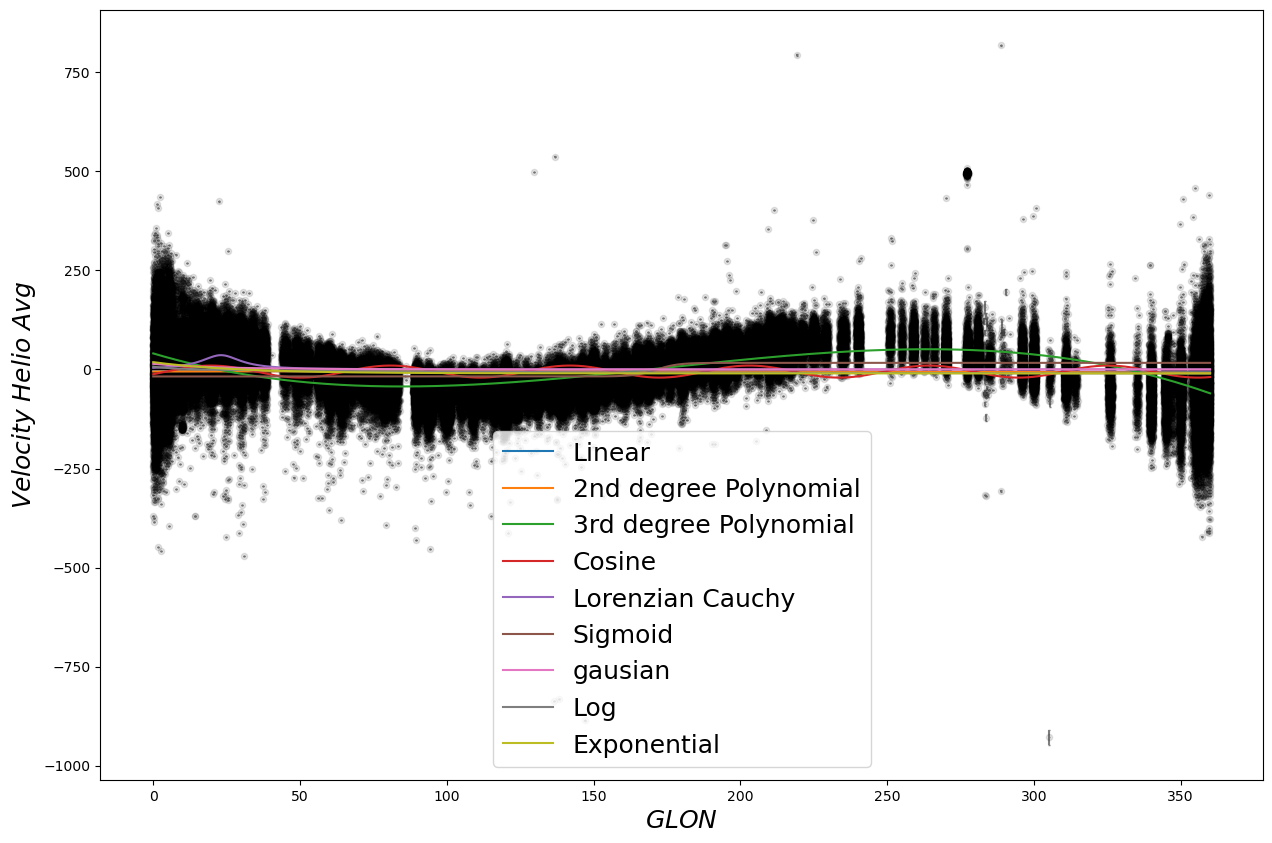

In [14]:
#problem 5 Select stars only with with  −10<𝐺𝐿𝐴𝑇<10 Fit {\bf GLON vs. VHEILO_AVG (VERR)



mask_1 = ((star['GLAT'][good] > -10) & (star['GLAT'][good] < 10)) & ((star['VHELIO_AVG'][good]) < 1e5)
xdat = star['GLON'][good][mask_1]
ydat = star['VHELIO_AVG'][good][mask_1]
ydat_err = star['VERR'][good][mask_1]
xdat_err = 0

slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err)
a_poly_2,b_poly_2,c_poly_2 = mcFit3(poly2, xdat, ydat, ydat_err, xdat_err)
#print(a_poly_2,b_poly_2,c_poly_2)
a_poly_3,b_poly_3,c_poly_3,d_poly_3 = mcFit4(poly3, xdat, ydat, ydat_err, xdat_err)
#print(a_poly_3,b_poly_3,c_poly_3,d_poly_3)
a_cos,b_cos,c_cos,d_cos = mcFit4(cosfit, xdat, ydat, ydat_err, xdat_err, p0=[15,-0.1,2,0.5])
#print(a_cos,b_cos,c_cos,d_cos)
mu, sigma = mcFit2(gausian,xdat, ydat, ydat_err, xdat_err, p0=[0.1,20])
#print(mu,sigma)
a_lorentz, b_lorentz, c_lorentz = mcFit3(lorentzian_cauchy,xdat, ydat, ydat_err, xdat_err)
#print(a_lorentz, b_lorentz, c_lorentz)
a_sig, b_sig, c_sig, d_sig = mcFit4(sigmoid, xdat, ydat, ydat_err, xdat_err, p0=[200,-1,-40,20])
#print(a_sig, b_sig, c_sig, d_sig)
a_4,b_4,c_4,d_4 = mcFit4(logfit, xdat, ydat, ydat_err, xdat_err, p0=[-4,5,10,7])###############
#print(a_4,b_4,c_4,d_4)
a_exp,b_exp,c_exp,d_exp = mcFit4(exponential,xdat, ydat, ydat_err, xdat_err, p0=[1,-0.01,1,1])
#print(a_exp,b_exp,c_exp,d_exp)


xfine = np.linspace(0, 360, 1000)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(xdat,ydat,s=20,c='black', alpha=0.1)
ax.errorbar(xdat,ydat,yerr=ydat_err, c='tab:gray', 
            fmt='.', markersize=0.75, capsize=1 ,zorder=0)

ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')
ax.plot(xfine, poly2(xfine, np.mean(a_poly_2), np.mean(b_poly_2), np.mean(c_poly_2)), label='2nd degree Polynomial')
ax.plot(xfine, poly3(xfine, np.mean(a_poly_3), np.mean(b_poly_3), np.mean(c_poly_3), np.mean(d_poly_3)), label='3rd degree Polynomial')
ax.plot(xfine, cosfit(xfine, np.mean(a_cos), np.mean(b_cos), np.mean(c_cos), np.mean(d_cos)), label='Cosine')
ax.plot(xfine, lorentzian_cauchy(xfine, np.mean(a_lorentz), np.mean(b_lorentz), np.mean(c_lorentz)), label='Lorenzian Cauchy')
ax.plot(xfine, sigmoid(xfine, np.mean(a_sig), np.mean(b_sig), np.mean(c_sig),np.mean(d_sig)), label='Sigmoid')
ax.plot(xfine, gausian(xfine, np.mean(mu), np.mean(sigma)), label='Gausian')
ax.plot(xfine, logfit(xfine, np.mean(a_4), np.mean(b_4), np.mean(c_4), np.mean(d_4)), label='Log')
ax.plot(xfine, exponential(xfine, np.mean(a_exp), np.mean(b_exp), np.mean(c_exp), np.mean(d_exp)), label='Exponential')

plt.legend(loc='best', fontsize=18)



ax.set_xlabel('$GLON$', fontsize=18)
ax.set_ylabel('$Velocity$ $Helio$ $Avg$', fontsize=18)

plt.show()


C:\Users\April\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


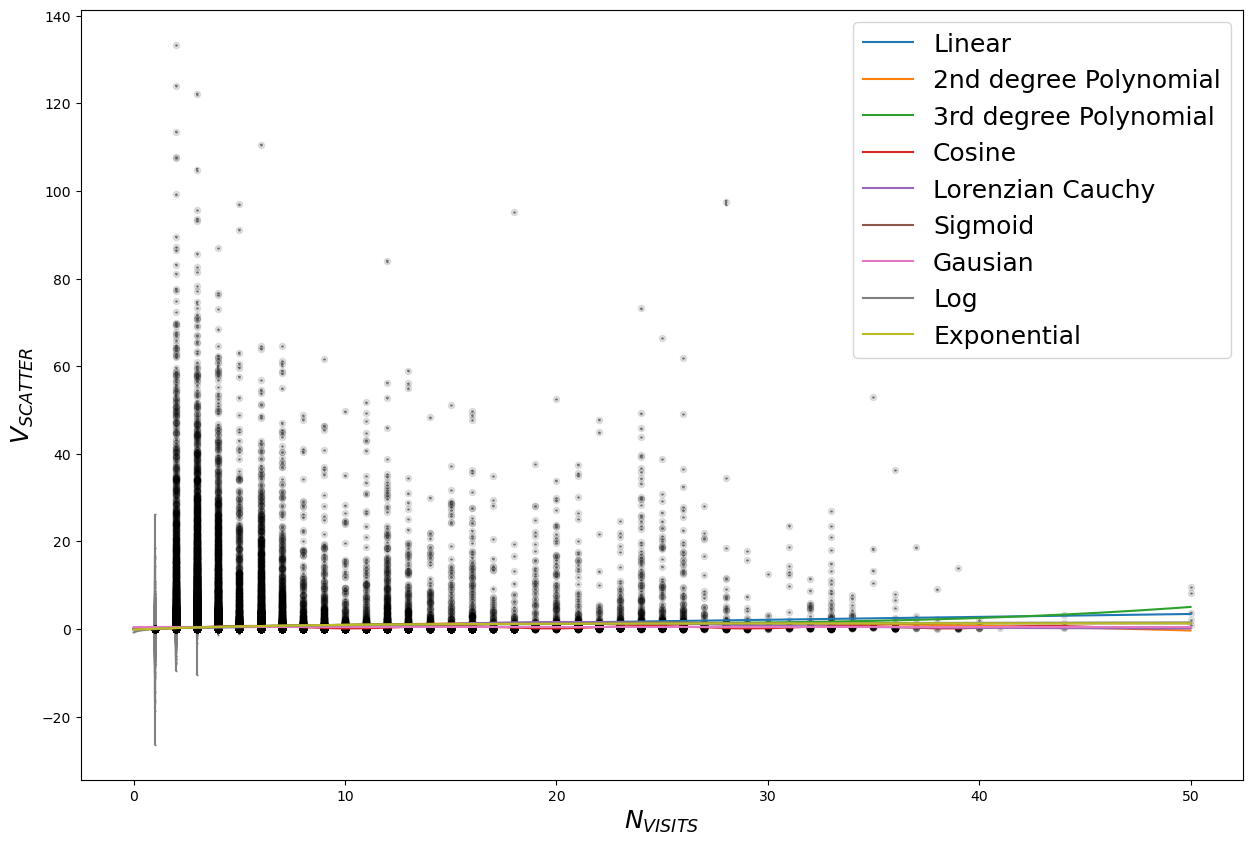

In [48]:
#problem 6 Fit {\bf NVISITS vs. VSCATTER (VERR) For NVISITS  >=1
mask_1 = ((star['NVISITS'][good] == 1) | (star['NVISITS'][good] > 1))

xdat = star['NVISITS'][good][mask_1]
ydat = star['VSCATTER'][good][mask_1]
ydat_err = star['VERR'][good][mask_1]
xdat_err = 0 #because there is no error in the x direction

slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err)
a_poly_2,b_poly_2,c_poly_2 = mcFit3(poly2, xdat, ydat, ydat_err, xdat_err)
#print(a_poly_2,b_poly_2,c_poly_2)
a_poly_3,b_poly_3,c_poly_3,d_poly_3 = mcFit4(poly3, xdat, ydat, ydat_err, xdat_err)
#print(a_poly_3,b_poly_3,c_poly_3,d_poly_3)
a_cos,b_cos,c_cos,d_cos = mcFit4(cosfit, xdat, ydat, ydat_err, xdat_err)
#print(a_cos,b_cos,c_cos,d_cos)
mu, sigma = mcFit2(gausian,xdat, ydat, ydat_err, xdat_err, p0=[0.1,4])
#print(mu,sigma)
a_lorentz, b_lorentz, c_lorentz = mcFit3(lorentzian_cauchy,xdat, ydat, ydat_err, xdat_err)
#print(a_lorentz, b_lorentz, c_lorentz)
a_sig, b_sig, c_sig, d_sig = mcFit4(sigmoid, xdat, ydat, ydat_err, xdat_err)
#print(a_sig, b_sig, c_sig, d_sig)
a_4,b_4,c_4,d_4 = mcFit4(logfit, xdat, ydat, ydat_err, xdat_err)
#print(a_4,b_4,c_4,d_4)
a_exp,b_exp,c_exp,d_exp = mcFit4(exponential,xdat, ydat, ydat_err, xdat_err, p0=[1.1,-4,3,0])
#print(a_exp,b_exp,c_exp,d_exp)

xfine = np.linspace(0, 50, 1000)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(xdat,ydat,s=20,c='black',alpha=0.1)
ax.errorbar(xdat,ydat,yerr=ydat_err, c='tab:gray',fmt='.', markersize=0.75, capsize=1 ,zorder=0)

ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')
ax.plot(xfine, poly2(xfine, np.mean(a_poly_2), np.mean(b_poly_2), np.mean(c_poly_2)), label='2nd degree Polynomial')
ax.plot(xfine, poly3(xfine, np.mean(a_poly_3), np.mean(b_poly_3), np.mean(c_poly_3), np.mean(d_poly_3)), label='3rd degree Polynomial')
ax.plot(xfine, cosfit(xfine, np.mean(a_cos), np.mean(b_cos), np.mean(c_cos), np.mean(d_cos)), label='Cosine')
ax.plot(xfine, lorentzian_cauchy(xfine, np.mean(a_lorentz), np.mean(b_lorentz), np.mean(c_lorentz)), label='Lorenzian Cauchy')
ax.plot(xfine, sigmoid(xfine, np.mean(a_sig), np.mean(b_sig), np.mean(c_sig),np.mean(d_sig)), label='Sigmoid')
ax.plot(xfine, gausian(xfine, np.mean(mu), np.mean(sigma)), label='Gausian')
ax.plot(xfine, logfit(xfine, np.mean(a_4), np.mean(b_4), np.mean(c_4), np.mean(d_4)), label='Log')
ax.plot(xfine, exponential(xfine, np.mean(a_exp), np.mean(b_exp), np.mean(c_exp), np.mean(d_exp)), label='Exponential')

plt.legend(loc='best', fontsize=18)
ax.set_xlabel('$N_{VISITS}$', fontsize=18)
ax.set_ylabel('$V_{SCATTER}$', fontsize=18)

plt.show()

C:\Users\April\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


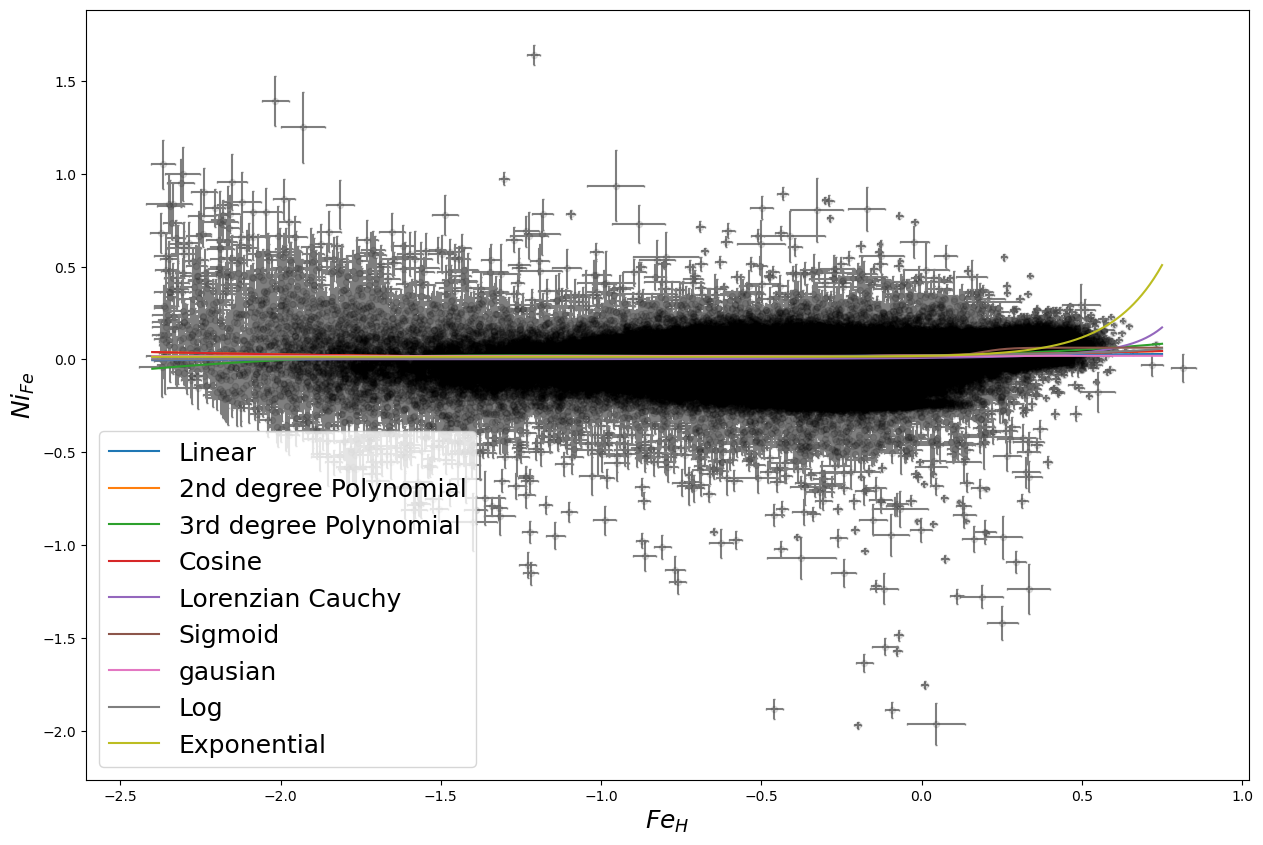

In [32]:
#problem 7 Fit {\bf Fe_H, (Fe_H_ERR) vs. NI_FE (NI_FE_ERR)
mask_1= ((star['Fe_H'][good] > -9999) & (star['NI_FE'][good] > -9999))
xdat = star['Fe_H'][good][mask_1]
ydat = star['NI_FE'][good][mask_1]
xdat_err = star['Fe_H_ERR'][good][mask_1]
ydat_err = star['NI_FE_ERR'][good][mask_1]

slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err)
a_poly_2,b_poly_2,c_poly_2 = mcFit3(poly2, xdat, ydat, ydat_err, xdat_err)
#print(a_poly_2,b_poly_2,c_poly_2)
a_poly_3,b_poly_3,c_poly_3,d_poly_3 = mcFit4(poly3, xdat, ydat, ydat_err, xdat_err)
#print(a_poly_3,b_poly_3,c_poly_3,d_poly_3)
a_cos,b_cos,c_cos,d_cos = mcFit4(cosfit, xdat, ydat, ydat_err, xdat_err)
#print(a_cos,b_cos,c_cos,d_cos)
mu, sigma = mcFit2(gausian,xdat, ydat, ydat_err, xdat_err, p0=[-1.6,1.8])

a_lorentz, b_lorentz, c_lorentz = mcFit3(lorentzian_cauchy,xdat, ydat, ydat_err, xdat_err, p0=[1,-0.3,0.1])
#print(a_lorentz, b_lorentz, c_lorentz)
a_sig, b_sig, c_sig, d_sig = mcFit4(sigmoid, xdat, ydat, ydat_err, xdat_err)
#print(a_sig, b_sig, c_sig, d_sig)
a_4,b_4,c_4,d_4 = mcFit4(logfit, xdat, ydat, ydat_err, xdat_err, p0=[-0.8,-0.2,1.2,0.1])
#print(a_4,b_4,c_4,d_4)
a_exp,b_exp,c_exp,d_exp = mcFit4(exponential,xdat, ydat, ydat_err, xdat_err,p0=[0,5,-1,-0.7])
#print(a_exp,b_exp,c_exp,d_exp)

xfine = np.linspace(-2.4, 0.75, 1000)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(xdat,ydat,s=20,c='black',alpha=0.1)
ax.errorbar(xdat,ydat,xerr= xdat_err,yerr=ydat_err, c='tab:gray', 
            fmt='.', markersize=0.75, capsize=1 ,zorder=0)
ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')
ax.plot(xfine, poly2(xfine, np.mean(a_poly_2), np.mean(b_poly_2), np.mean(c_poly_2)), label='2nd degree Polynomial')
ax.plot(xfine, poly3(xfine, np.mean(a_poly_3), np.mean(b_poly_3), np.mean(c_poly_3), np.mean(d_poly_3)), label='3rd degree Polynomial')
ax.plot(xfine, cosfit(xfine, np.mean(a_cos), np.mean(b_cos), np.mean(c_cos), np.mean(d_cos)), label='Cosine')
ax.plot(xfine, lorentzian_cauchy(xfine, np.mean(a_lorentz), np.mean(b_lorentz), np.mean(c_lorentz)), label='Lorenzian Cauchy')
ax.plot(xfine, sigmoid(xfine, np.mean(a_sig), np.mean(b_sig), np.mean(c_sig),np.mean(d_sig)), label='Sigmoid')
ax.plot(xfine, gausian(xfine, np.mean(mu), np.mean(sigma)), label='Gausian')
ax.plot(xfine, logfit(xfine, np.mean(a_4), np.mean(b_4), np.mean(c_4), np.mean(d_4)), label='Log')
ax.plot(xfine, exponential(xfine, np.mean(a_exp), np.mean(b_exp), np.mean(c_exp), np.mean(d_exp)), label='Exponential')

plt.legend(loc='best', fontsize=18)
ax.set_xlabel('$Fe_{H}$', fontsize=18)
ax.set_ylabel('$Ni_{Fe}$', fontsize=18)

plt.show()